In [1]:
# Import necessary libraries
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
from matplotlib import _contour
import plotly.graph_objects as go
from lal.antenna import AntennaResponse
from astropy.time import Time, TimeDelta
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, GeocentricTrueEcliptic

# Recommendations for Enabling Early Multi-Messenger Science in Rubin LSST

- This notebook contains: calculations to estimate LVK power in different areas of the sky within the Rubin LSST footprint.
- Aim: Estimate potential areas of the sky to prioritise for template acquistion during Rubin LSST Science Verification


Assumptions:
- LVK response for a given date and coordinates using L1, H1 and V1 fully operational.
- Using [Schutz 2011](https://arxiv.org/abs/1102.5421) for antenna power calculation.

This notebook by [Anais Möller](mailto:amoller@swin.edu.au) for Rubin LSST projections using inputs from [Jade Powell](jpowell@swin.edu.au).

In [2]:
# Define constants
DETECTORS = ['H1', 'L1', 'V1']
# Rubin Observatory (Cerro Pachón, Chile)
LOCATION = EarthLocation(
    lat=-30.2446 * u.deg,
    lon=-70.7494 * u.deg,
    height=2663 * u.m
)

In [3]:
# Used functions
# Function to calculate antenna response for a given RA, Dec, and time
def calculate_antenna_response(ras, decs, times):
    antenna_power_grid = np.zeros((len(decs), len(ras), len(times)))
    for i, dec in enumerate(decs):
        for j, ra in enumerate(ras):
            dic_resp = {
                detector: AntennaResponse(
                    detector,
                    ra=np.radians(ra),
                    dec=np.radians(dec),
                    psi=0,
                    times=times
                )
                for detector in DETECTORS
            }
            network_antenna_power_pattern = np.sum(
                [dic_resp[detector].plus**2 + dic_resp[detector].cross**2 for detector in dic_resp],
                axis=0
            )
            antenna_power_grid[i, j, :] = network_antenna_power_pattern
    return antenna_power_grid

import matplotlib.pyplot as plt

def plot_antenna_power_map(
    antenna_power_grid,
    ras,
    decs,
    ra_band,
    dec_band,
    idx_time=0,
    idx_arr=None,
    extra_ras=None,
    extra_decs=None,
    ax=None
):
    # Use provided axis or create one
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 3))

    # Plot the antenna power map
    im = ax.imshow(
        antenna_power_grid[:, :, idx_time],
        extent=[ras.min(), ras.max(), decs.min(), decs.max()],
        aspect='auto',
        origin='lower',
        cmap='viridis'
    )

    # Optional: overlay extra points
    if extra_ras is not None and extra_decs is not None:
        ax.scatter(extra_ras, extra_decs, color='grey', s=10, alpha=0.3, label='Extra Points')

    # Axis labels and title
    ax.set_xlabel('Right Ascension (deg)')
    ax.set_ylabel('Declination (deg)')
    if idx_arr is not None:
        idx_title = f'{idx_arr[idx_time]}'
    else:
        idx_title = idx_time
    ax.set_title(f'Antenna Power at {idx_title}', fontsize=8)

    # Overlay galactic plane
    ax.fill(ra_band, dec_band, color='red', alpha=0.3)

    ax.set_ylim(-80, 0)

    # Only add colorbar if not plotting in subplots
    if ax is None:
        plt.colorbar(im, ax=ax, label='Antenna Power')
        plt.tight_layout()
        plt.show()

    return im


# Function to calculate galactic plane polygon
def calculate_galactic_plane(wrapped=False):
    l_vals = np.linspace(0, 360, 1000)
    b_upper = 10 * np.ones_like(l_vals)
    b_lower = -10 * np.ones_like(l_vals)
    upper_edge = SkyCoord(l=l_vals * u.deg, b=b_upper * u.deg, frame='galactic').icrs
    lower_edge = SkyCoord(l=l_vals[::-1] * u.deg, b=b_lower[::-1] * u.deg, frame='galactic').icrs
    ra_band = np.concatenate([upper_edge.ra.deg, lower_edge.ra.deg]) % 360
    dec_band = np.concatenate([upper_edge.dec.deg, lower_edge.dec.deg])
    if wrapped:
        # Wrap RA for Mollweide projection
        ra_band_wrapped = (ra_band + 180) % 360 - 180  # wrap for Mollweide
        return ra_band_wrapped, dec_band
    else:
        return ra_band, dec_band

# Function to calculate day-night boundary
def calculate_day_night_boundary(ras, decs, defined_time):
    RA_grid, DEC_grid = np.meshgrid(ras, decs)
    sky_coords = SkyCoord(ra=RA_grid * u.deg, dec=DEC_grid * u.deg, frame='icrs')
    altaz = sky_coords.transform_to(AltAz(obstime=defined_time, location=LOCATION))
    alt = altaz.alt.value
    cs = _contour.QuadContourGenerator(RA_grid, DEC_grid, alt, None, False, 0)
    contours = cs.create_contour(0)
    return contours

# plotly

def calculate_night_region_contours(ras, decs, defined_time, location):
    """
    Compute the night region contours (altitude < 0°) from a grid of RA/Dec values.
    
    Parameters:
    - ras: 1D array of Right Ascension in degrees
    - decs: 1D array of Declination in degrees
    - defined_time: astropy.time.Time object (UTC time)
    - location: astropy.coordinates.EarthLocation of the observatory
    
    Returns:
    - contours: List of numpy arrays representing the contour lines at alt = 0°
    """
    import numpy as np
    from astropy.coordinates import SkyCoord, AltAz
    import astropy.units as u
    from matplotlib import _contour

    # Create the RA/Dec grid
    RA_grid, DEC_grid = np.meshgrid(ras, decs)

    # Convert to AltAz to get altitude above horizon
    sky_coords = SkyCoord(ra=RA_grid * u.deg, dec=DEC_grid * u.deg, frame='icrs')
    altaz = sky_coords.transform_to(AltAz(obstime=defined_time, location=location))
    alt = altaz.alt.reshape(RA_grid.shape)
    # Use contour generator to get 0° altitude contour (i.e., the horizon)
    try:
        cs = _contour.QuadContourGenerator(RA_grid, DEC_grid, alt, None, False, 0)
        contours = cs.create_contour(0)  # Contour for alt = 0 (horizon)
    except Exception as e:
        print(f"Contour generation failed: {e}")
        contours = []

    return contours


def plot_antenna_power_mollweide(
    antenna_power_grid, ras, decs,
    galactic_ra_band, galactic_dec_band,
    night_contours=None, time_index=0
):
    RA_grid, DEC_grid = np.meshgrid(ras, decs)
    ra_flat = RA_grid.flatten()
    dec_flat = DEC_grid.flatten()
    power_flat = antenna_power_grid[:, :, time_index].flatten()
    ra_flat_wrapped = (ra_flat + 180) % 360 - 180

    fig = go.Figure()

    # Antenna Power Map
    fig.add_trace(go.Scattergeo(
        lon=ra_flat_wrapped,
        lat=dec_flat,
        mode='markers',
        marker=dict(
            size=6,
            color=power_flat,
            colorscale='Viridis',
            colorbar=dict(title='Power'),
            cmin=power_flat.min(),
            cmax=power_flat.max()
        ),
        hoverinfo='text',
        text=[f'RA: {ra:.1f}°, Dec: {dec:.1f}°, Power: {p:.2f}' for ra, dec, p in zip(ra_flat, dec_flat, power_flat)],
        name='Antenna Power'
    ))

    # Galactic Plane
    fig.add_trace(go.Scattergeo(
        lon=galactic_ra_band,
        lat=galactic_dec_band,
        mode='lines',
        fill='toself',
        fillcolor='rgba(200, 100, 100, 0.3)',
        line=dict(width=0),
        hoverinfo='skip',
        showlegend=True,
        name='Galactic Plane'
    ))

    # Night Region (if provided)
    if night_contours is not None:
        # Plot the contour as a filled shadow
        for segment in night_contours:
            ra_contour = segment[:, 0]
            dec_contour = segment[:, 1]

            # Wrap RA to [-180, 180] for Mollweide
            ra_wrapped = (ra_contour + 180) % 360 - 180

            fig.add_trace(go.Scattergeo(
                lon=ra_wrapped,
                lat=dec_contour,
                mode='lines',
                fill='toself',
                fillcolor='rgba(0, 0, 0, 0.4)',
                line=dict(width=0),
                hoverinfo='skip',
                showlegend=False,
                name='Night Region'
            ))


    fig.update_geos(
        projection_type="mollweide",
        showland=False,
        showcoastlines=False,
        lataxis_showgrid=True,
        lonaxis_showgrid=True,
    )

    fig.update_layout(
        title=f'Antenna Power Pattern + Galactic Plane + Night Region {time_index}',
        geo=dict(resolution=50, showframe=False),
        height=300,
        width=600,
        margin={"r":0,"t":30,"l":0,"b":0}
    )

    fig.show()

# Search for fields to propose
- Antenna power moves through the night somewhere between dec -30,-50. 
- Select a range of dec, look visibility in Rubin in the template (SV July-September) and potential ToO period (September-November) + avoid galaxy

# Rubin ToO programm + LVK operational window September 10th 2025 - November 18th 2025

GPS times array: [1.44153362e+09 1.44154226e+09 1.44155090e+09 1.44155954e+09
 1.44156818e+09 1.44157682e+09 1.44158546e+09 1.44159410e+09
 1.44160274e+09 1.44161138e+09 1.44162002e+09]
Index to Time dict: {0: <Time object: scale='utc' format='iso' value=2025-09-10 10:00:00.000>, 1: <Time object: scale='utc' format='iso' value=2025-09-10 12:24:00.000>, 2: <Time object: scale='utc' format='iso' value=2025-09-10 14:48:00.000>, 3: <Time object: scale='utc' format='iso' value=2025-09-10 17:12:00.000>, 4: <Time object: scale='utc' format='iso' value=2025-09-10 19:36:00.000>, 5: <Time object: scale='utc' format='iso' value=2025-09-10 22:00:00.000>, 6: <Time object: scale='utc' format='iso' value=2025-09-11 00:24:00.000>, 7: <Time object: scale='utc' format='iso' value=2025-09-11 02:48:00.000>, 8: <Time object: scale='utc' format='iso' value=2025-09-11 05:12:00.000>, 9: <Time object: scale='utc' format='iso' value=2025-09-11 07:36:00.000>, 10: <Time object: scale='utc' format='iso' value=2025

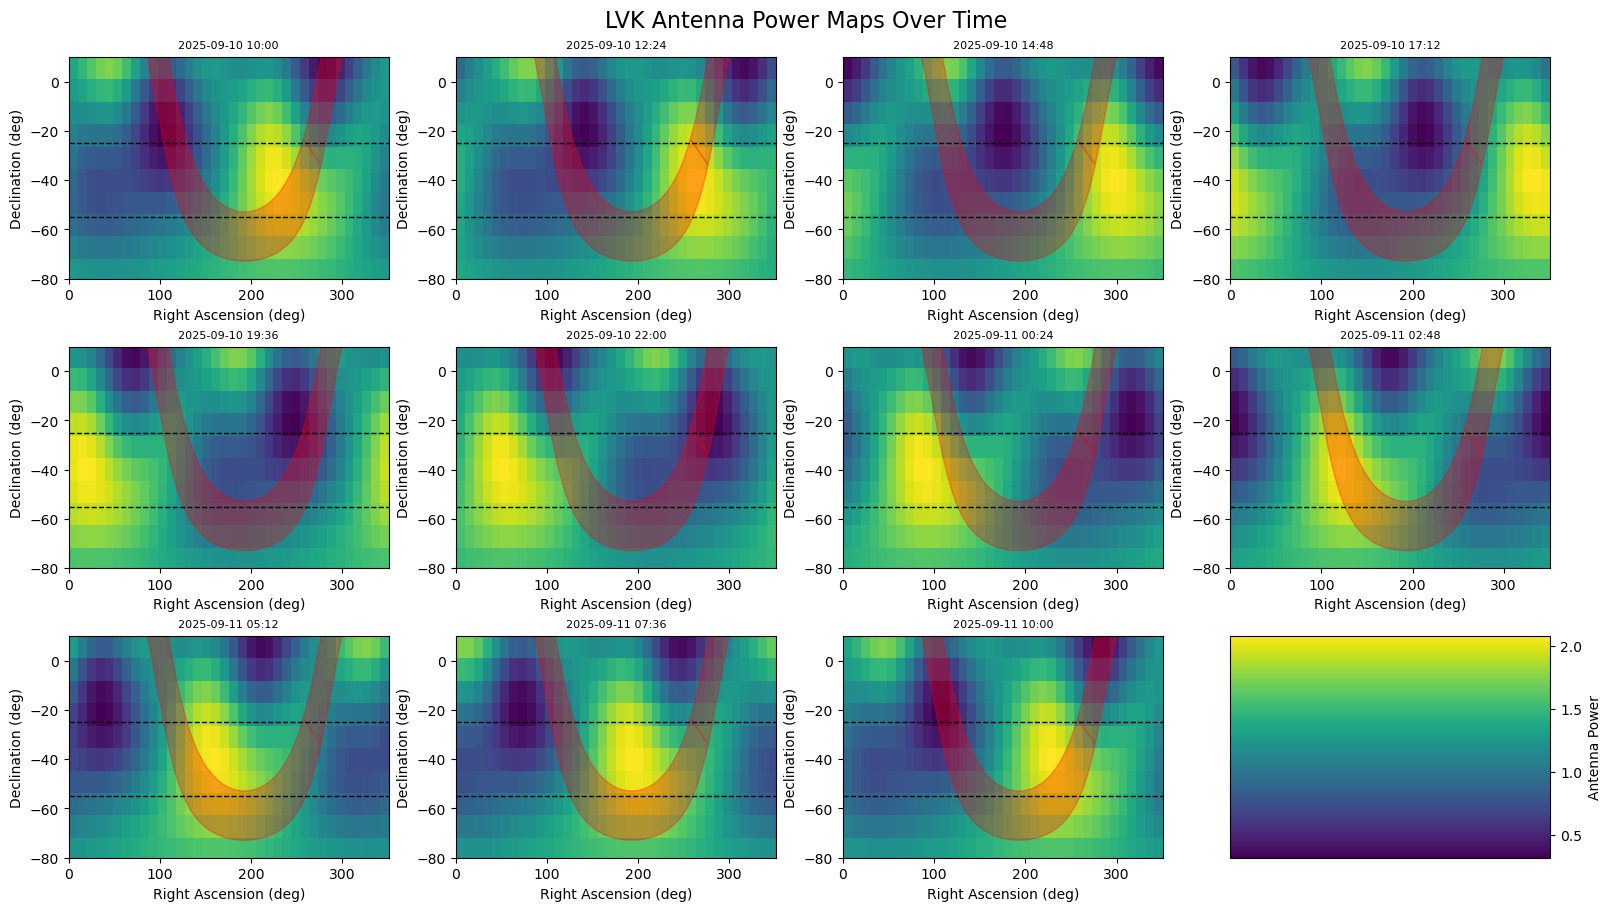

In [4]:
# Define time range
t0 = Time('2025-09-10 10:00:00', format='iso', scale='utc') # around 5pm that day?
t1 = Time('2025-09-11 11:00:02', format='iso', scale='utc')

deltasubnight = TimeDelta(0.1 * 24 * 3600, format='sec')  # 14 days

times_list = []
current_time = t0
while current_time <= t1:
    times_list.append(current_time)
    current_time += deltasubnight

times = Time(times_list)
times_gps_array = times.gps  # numpy array of GPS seconds (floats)

# Dictionary mapping index to full Time object
index_time_dict = {i: t for i, t in enumerate(times)}

print("GPS times array:", times_gps_array)
print("Index to Time dict:", index_time_dict)

# Create reverse lookup: GPS time → index
gps_to_index = {t.gps: i for i, t in index_time_dict.items()}


# Define RA and Dec grid
ras = np.arange(0, 360, 10)
decs = np.arange(-90, 20, 10)

# Calculate antenna response
antenna_power_grid = calculate_antenna_response(ras, decs, times_gps_array)

# # Matplotlib
# # Calculate galactic plane
galactic_ra_band, galactic_dec_band = calculate_galactic_plane(wrapped=False)


# Prepare subplots
n_times = len(times)
ncols = 4
nrows = int(np.ceil(n_times / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 3*nrows), constrained_layout=True)
axes = axes.flatten()  # flatten to index easily

# Loop over times and plot each antenna power map
for idx in range(n_times):
    ax = axes[idx]
    last_im = plot_antenna_power_map(
        antenna_power_grid, ras, decs,
        galactic_ra_band, galactic_dec_band,
        idx_time=idx, idx_arr=times,
        ax=ax  # this is key to using subplots
    )
    ax.hlines(-25, 0, 360, color='black', linestyle='--', linewidth=1)
    ax.hlines(-55, 0, 360, color='black', linestyle='--', linewidth=1)
    ax.set_ylim(-80, 10)
    ax.set_xlim(0, 351)
    ax.set_title(times[idx].iso[:16], fontsize=8)

# Colorbar in unused space
if n_times < len(axes):
    cax = axes[n_times]
else:
    fig.subplots_adjust(right=0.88)
    cax = fig.add_axes([0.9, 0.15, 0.02, 0.7])

fig.colorbar(last_im, cax=cax, label='Antenna Power')

# Remove unused axes, except the one used for colorbar
for ax in axes[n_times+1:]:
    fig.delaxes(ax)

plt.suptitle("LVK Antenna Power Maps Over Time", fontsize=16)
plt.show()


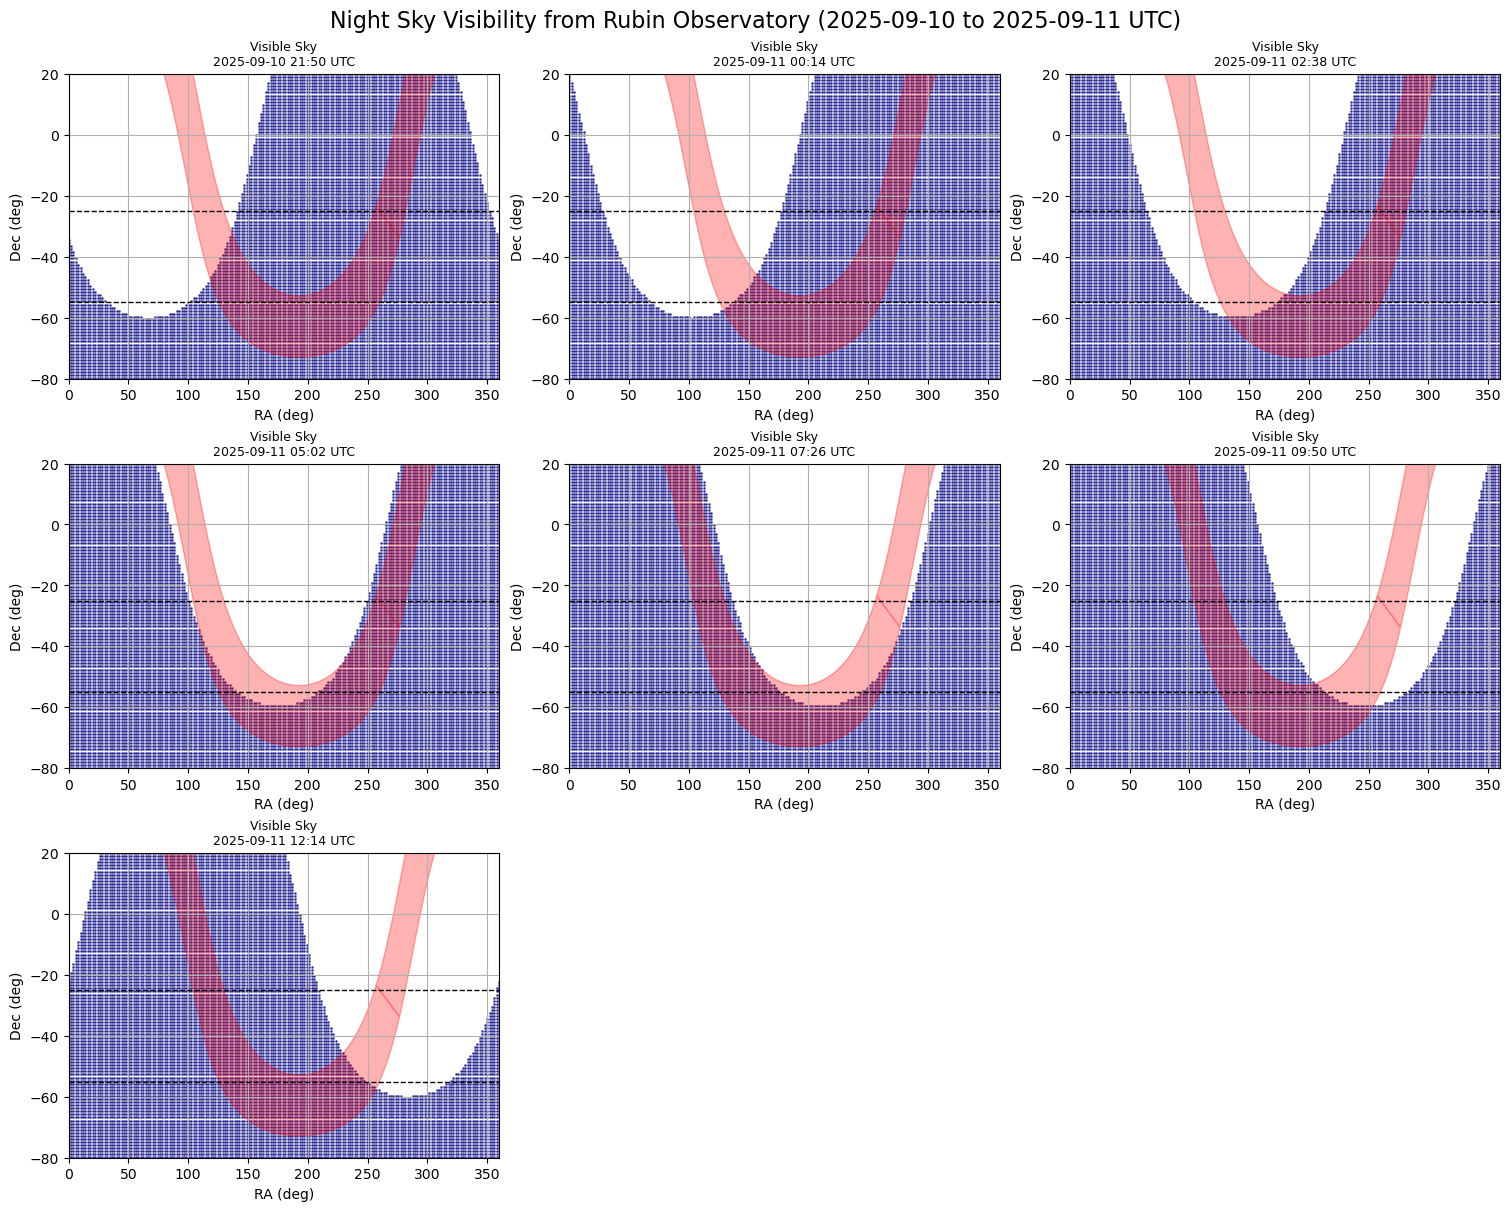

In [5]:
# Night sky visibility from Rubin Observatory (2025-09-10 to 2025-09-11 UTC)

# Time range: 2025-09-10 night at Rubin (UTC)
t0 = Time('2025-09-10 21:50:00', scale='utc')  # sunset (UTC)
t1 = Time('2025-09-11 11:30:00', scale='utc')  # sunrise (UTC)

delta_t = TimeDelta(0.1 * u.day)  # 0.1 day = 2.4 hours
times = t0 + np.arange(0, (t1 - t0)/delta_t + 1) * delta_t

# 3. Sky grid (RA/Dec)
ras = np.linspace(0, 360, 180)
decs = np.linspace(-90, 20, 110)
RA_grid, DEC_grid = np.meshgrid(ras, decs)
sky_coords = SkyCoord(ra=RA_grid.flatten()*u.deg, dec=DEC_grid.flatten()*u.deg, frame='icrs')

# 4. Plot setup
n_times = len(times)
ncols = 3
nrows = int(np.ceil(n_times / ncols))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 4*nrows), constrained_layout=True)
axes = axes.flatten()

# 5. Loop over time steps and plot visible sky
for i, time in enumerate(times):
    ax = axes[i]

    altaz = sky_coords.transform_to(AltAz(obstime=time, location=LOCATION))
    mask_visible = altaz.alt > 0*u.deg  # Only above the horizon

    ra_visible = RA_grid.flatten()[mask_visible]
    dec_visible = DEC_grid.flatten()[mask_visible]

    ax.scatter(ra_visible, dec_visible, s=1, color='navy', alpha=0.6)
    ax.fill(galactic_ra_band, galactic_dec_band, color='red', alpha=0.3)

    ax.hlines(-25, 0, 360, color='black', linestyle='--', linewidth=1)
    ax.hlines(-55, 0, 360, color='black', linestyle='--', linewidth=1)
    ax.set_xlim(0, 360)
    ax.set_ylim(-80, 20)
    ax.set_title(f"Visible Sky\n{time.iso[:16]} UTC", fontsize=9)
    ax.set_xlabel("RA (deg)")
    ax.set_ylabel("Dec (deg)")
    ax.grid(True)

# Remove unused subplots
for ax in axes[n_times:]:
    fig.delaxes(ax)

plt.suptitle("Night Sky Visibility from Rubin Observatory (2025-09-10 to 2025-09-11 UTC)", fontsize=16)
plt.show()


# Adding proposed strategy of Rubin LSST Science Verification observations
- Proposed strategy: 10 degrees around the ecliptic
- This will be outside the estimated maximum antenna power of LVK during this time.


GPS times array: [1.44153362e+09 1.44154226e+09 1.44155090e+09 1.44155954e+09
 1.44156818e+09 1.44157682e+09 1.44158546e+09 1.44159410e+09
 1.44160274e+09 1.44161138e+09 1.44162002e+09]
Index to Time dict: {0: <Time object: scale='utc' format='iso' value=2025-09-10 10:00:00.000>, 1: <Time object: scale='utc' format='iso' value=2025-09-10 12:24:00.000>, 2: <Time object: scale='utc' format='iso' value=2025-09-10 14:48:00.000>, 3: <Time object: scale='utc' format='iso' value=2025-09-10 17:12:00.000>, 4: <Time object: scale='utc' format='iso' value=2025-09-10 19:36:00.000>, 5: <Time object: scale='utc' format='iso' value=2025-09-10 22:00:00.000>, 6: <Time object: scale='utc' format='iso' value=2025-09-11 00:24:00.000>, 7: <Time object: scale='utc' format='iso' value=2025-09-11 02:48:00.000>, 8: <Time object: scale='utc' format='iso' value=2025-09-11 05:12:00.000>, 9: <Time object: scale='utc' format='iso' value=2025-09-11 07:36:00.000>, 10: <Time object: scale='utc' format='iso' value=2025

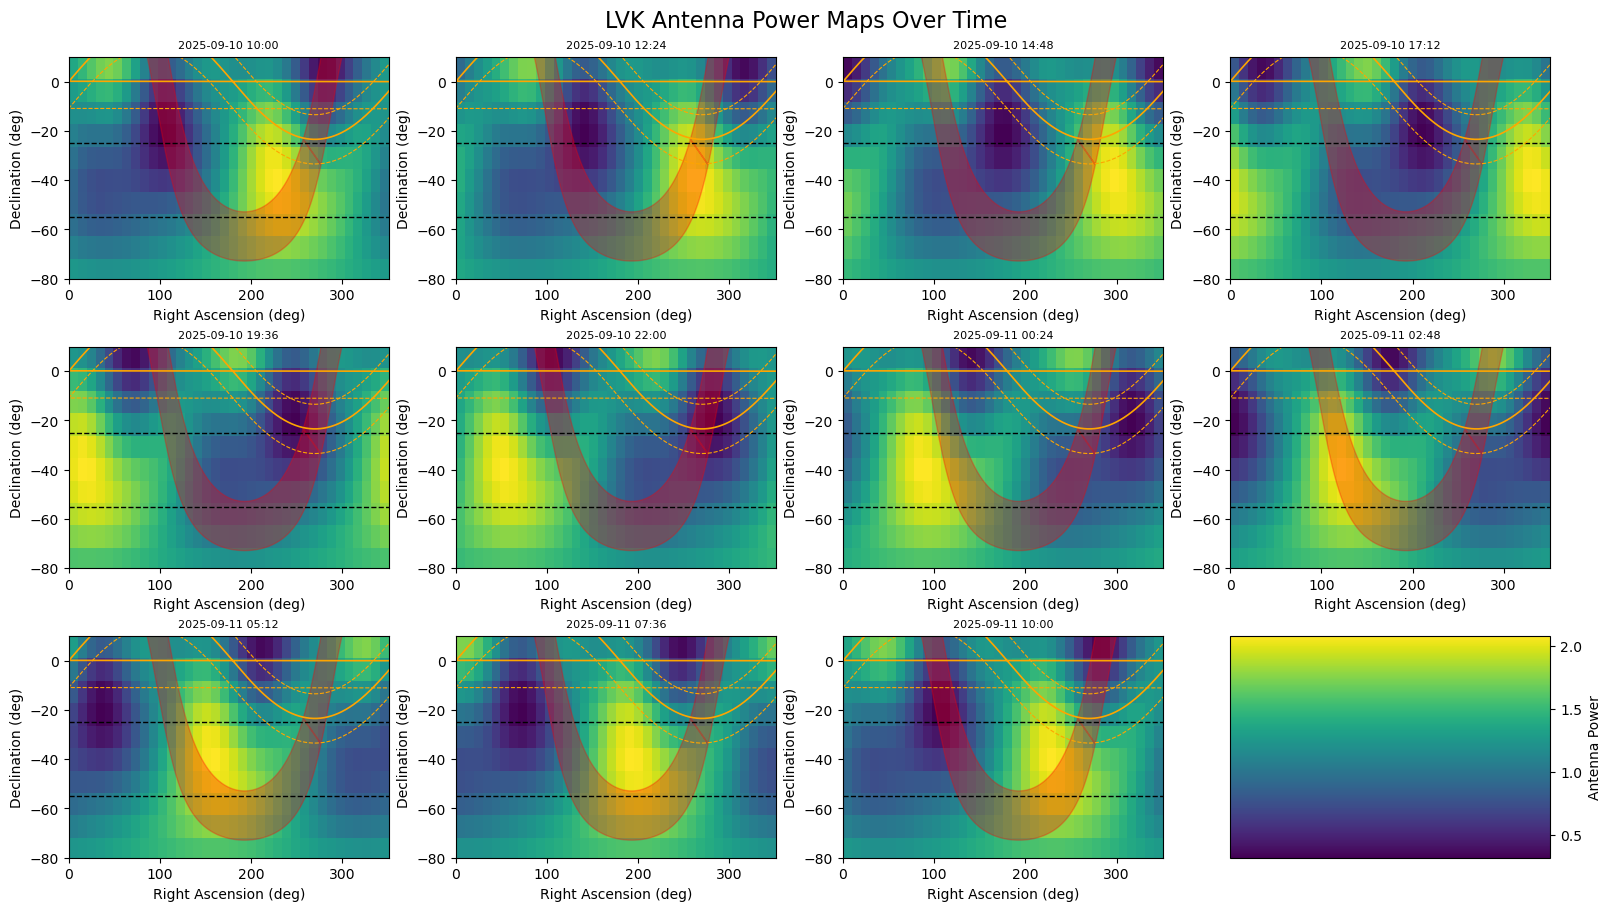

In [6]:

# Define ecliptic longitude range (0° to 360°)
lon = np.linspace(0, 360, 1000) * u.deg

# Ecliptic latitude bands: 0°, +10°, -10°
lat_0 = np.zeros_like(lon)
lat_p10 = np.full_like(lon, 10 * u.deg)
lat_m10 = np.full_like(lon, -10 * u.deg)

# Convert to RA/Dec for plotting
def ecliptic_to_icrs(longitudes, latitudes):
    ecliptic_coords = SkyCoord(lon=longitudes, lat=latitudes, frame=GeocentricTrueEcliptic, obstime=t0)
    return ecliptic_coords.icrs.ra.deg, ecliptic_coords.icrs.dec.deg

ra_0, dec_0 = ecliptic_to_icrs(lon, lat_0)
ra_p10, dec_p10 = ecliptic_to_icrs(lon, lat_p10)
ra_m10, dec_m10 = ecliptic_to_icrs(lon, lat_m10)


# Define time range
t0 = Time('2025-09-10 10:00:00', format='iso', scale='utc') # around 5pm that day?
t1 = Time('2025-09-11 11:00:02', format='iso', scale='utc')

deltasubnight = TimeDelta(0.1 * 24 * 3600, format='sec')  # 14 days

times_list = []
current_time = t0
while current_time <= t1:
    times_list.append(current_time)
    current_time += deltasubnight

times = Time(times_list)
times_gps_array = times.gps  # numpy array of GPS seconds (floats)

# Dictionary mapping index to full Time object
index_time_dict = {i: t for i, t in enumerate(times)}

print("GPS times array:", times_gps_array)
print("Index to Time dict:", index_time_dict)

# Create reverse lookup: GPS time → index
gps_to_index = {t.gps: i for i, t in index_time_dict.items()}


# Define RA and Dec grid
ras = np.arange(0, 360, 10)
decs = np.arange(-90, 20, 10)

# Calculate antenna response
antenna_power_grid = calculate_antenna_response(ras, decs, times_gps_array)

# # Matplotlib
# # Calculate galactic plane
galactic_ra_band, galactic_dec_band = calculate_galactic_plane(wrapped=False)


# Prepare subplots
n_times = len(times)
ncols = 4
nrows = int(np.ceil(n_times / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 3*nrows), constrained_layout=True)
axes = axes.flatten()  # flatten to index easily

# Loop over times and plot each antenna power map
for idx in range(n_times):
    ax = axes[idx]
    last_im = plot_antenna_power_map(
        antenna_power_grid, ras, decs,
        galactic_ra_band, galactic_dec_band,
        idx_time=idx, idx_arr=times,
        ax=ax  # this is key to using subplots
    )

        # Overplot ecliptic band
    ax.plot(ra_0, dec_0, color='orange', lw=1.2, label='Ecliptic')
    ax.plot(ra_p10, dec_p10, color='orange', lw=0.8, linestyle='--')
    ax.plot(ra_m10, dec_m10, color='orange', lw=0.8, linestyle='--')


    ax.hlines(-25, 0, 360, color='black', linestyle='--', linewidth=1)
    ax.hlines(-55, 0, 360, color='black', linestyle='--', linewidth=1)
    ax.set_ylim(-80, 10)
    ax.set_xlim(0, 351)
    ax.set_title(times[idx].iso[:16], fontsize=8)

# Colorbar in unused space
if n_times < len(axes):
    cax = axes[n_times]
else:
    fig.subplots_adjust(right=0.88)
    cax = fig.add_axes([0.9, 0.15, 0.02, 0.7])

fig.colorbar(last_im, cax=cax, label='Antenna Power')

# Remove unused axes, except the one used for colorbar
for ax in axes[n_times+1:]:
    fig.delaxes(ax)

plt.suptitle("LVK Antenna Power Maps Over Time", fontsize=16)
plt.show()


## The Rubin LSST Science Verification plan 1 wont gather templates for the highest sensitivity areas of the LVK network (L1, H1, V1) during O4. Thus, we propose to extend the SV images to lower declinations for rising fields in the foorprint. 

# Comparison of power ratio between SV default strategy and extending coverage to lower declinations
ToO maximising area: assuming Rubin gathers templates for fields.
- Outside the galactic plane (not within -10<gal<10)
- Declination: -55< DEC< -25 (degrees)
- Rising fields: RA>100

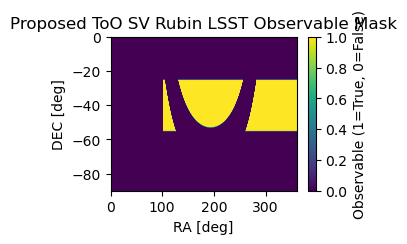

In [7]:
# Define the mask for proposed observable fields
ra = np.linspace(0, 360, 10000)  # degrees
dec = np.linspace(-90, 0, 5000)  # degrees
RA, DEC = np.meshgrid(ra, dec)

# Flatten to create SkyCoord
sky_coords = SkyCoord(ra=RA.ravel()*u.deg, dec=DEC.ravel()*u.deg, frame='icrs')

# Convert to Galactic coordinates
galactic = sky_coords.galactic
gal_b = galactic.b.deg  # Galactic latitude

# Build mask
mask = (
    (np.abs(gal_b) > 10) &       # Outside galactic plane
    (sky_coords.dec.deg > -55) & 
    (sky_coords.dec.deg < -25) & # DEC in range
    (sky_coords.ra.deg > 100)    # RA > 100
)

# Reshape back to 2D if needed
mask_2d = mask.reshape(DEC.shape)

# visualize the mask
plt.figure(figsize=(3, 2))
plt.imshow(mask_2d, origin='lower', extent=[0, 360, -90, 0], aspect='auto')
plt.xlabel("RA [deg]")
plt.ylabel("DEC [deg]")
plt.title("Proposed ToO SV Rubin LSST Observable Mask")
plt.colorbar(label="Observable (1=True, 0=False)")
plt.show()


In [8]:
# Compute the integrated power over the night of 11th September 2025 and 18th November 2025 for ToO suggested fields

print("ToO proposed fields")
# observation dates
nights = {
    "2025-09-11": ("2025-09-11 10:00:00", "2025-09-12 11:00:02"),
    "2025-11-18": ("2025-11-18 10:00:00", "2025-11-19 11:00:02")
}
# ra,dec grid
ras = np.arange(0, 360, 10)       # 36 values
decs = np.arange(-90, 20, 10)     # 11 values

# Create Rubin LSST visibility mask once
RA_grid, DEC_grid = np.meshgrid(ras, decs)
RA_flat = RA_grid.flatten()
DEC_flat = DEC_grid.flatten()
coords = SkyCoord(ra=RA_flat * u.deg, dec=DEC_flat * u.deg, frame='icrs')
gal_b = coords.galactic.b.deg
mask_flat = (
    (np.abs(gal_b) > 10) &
    (DEC_flat > -55) & (DEC_flat < -25) &
    (RA_flat > 100)
)
mask = mask_flat.reshape(DEC_grid.shape)  # shape: (11, 36)

# Sub-night time spacing
deltasubnight = TimeDelta(0.1 * 24 * 3600* u.s)  # 2.4 hours

# Store results
night_totals = {}
both_nigths_times = []
both_nights_antenna_power_integrated = []
total_power_ToO = {}
for night_label, (start_time_str, end_time_str) in nights.items():
    # Time setup
    t0 = Time(start_time_str, format='iso', scale='utc')
    t1 = Time(end_time_str, format='iso', scale='utc')
    times = []
    t = t0
    while t <= t1:
        times.append(t)
        t += deltasubnight
    times = Time(times)
    both_nigths_times.append(times)
    times_gps_array = times.gps

    # Compute antenna power
    antenna_power_grid = calculate_antenna_response(ras, decs, times_gps_array)

    # Apply Rubin LSST visibility mask
    masked_antenna_power = antenna_power_grid * mask[:, :, np.newaxis]

    # Integrate over RA, Dec
    antenna_power_integrated = np.sum(masked_antenna_power, axis=(0, 1))
    both_nights_antenna_power_integrated.append(antenna_power_integrated)

    # Total power over time
    delta_t_sec = deltasubnight.to(u.s).value
    total_power_ToO[night_label] = np.sum(antenna_power_integrated) * delta_t_sec

    night_totals[night_label] = total_power_ToO[night_label]
    print(f"{night_label}: total antenna power = {total_power_ToO[night_label]:.2e}")
# plt.figure(figsize=(5, 2))

# for i, (night_label, antenna_power_integrated) in enumerate(zip(nights.keys(), both_nights_antenna_power_integrated)):
#     times = both_nigths_times[i]
#     elapsed_hours = (times - times[0]).to(u.hour).value  # elapsed time in hours since start of that night
#     plt.plot(elapsed_hours, antenna_power_integrated, marker='o', label=f'Integrated Antenna Power ({night_label})')

# plt.xlabel("Elapsed Time [hours]")
# plt.ylabel("Power")
# plt.title("Antenna Power over Rubin-Observable Fields")
# plt.grid(True)
# plt.legend()
# plt.tight_layout()
# plt.show()

ToO proposed fields
2025-09-11: total antenna power = 6.44e+06
2025-11-18: total antenna power = 6.36e+06


SV proposed fields


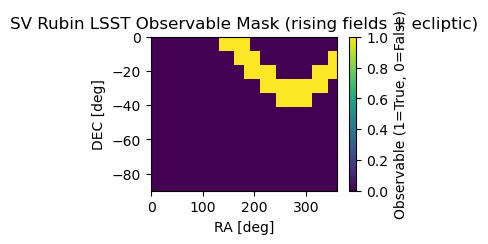

2025-09-11: total antenna power = 4.78e+06
2025-11-18: total antenna power = 4.69e+06


In [11]:
# Compute the integrated power over the night of 11th September 2025 and 18th November 2025 for SV proposed fields (ecliptic)

print("SV proposed fields")

# observation dates
nights = {
    "2025-09-11": ("2025-09-11 10:00:00", "2025-09-12 11:00:02"),
    "2025-11-18": ("2025-11-18 10:00:00", "2025-11-19 11:00:02")
}
# ra,dec grid
ras = np.arange(0, 360, 10)       # 36 values
decs = np.arange(-90, 20, 10)     # 11 values

# Create Rubin LSST visibility mask once
RA_grid, DEC_grid = np.meshgrid(ras, decs)
RA_flat = RA_grid.flatten()
DEC_flat = DEC_grid.flatten()
coords = SkyCoord(ra=RA_flat * u.deg, dec=DEC_flat * u.deg, frame='icrs')
gal_b = coords.galactic.b.deg


# ecliptic
ecliptic = coords.barycentrictrueecliptic
ecl_lat = ecliptic.lat.deg


mask_flat = (
    (np.abs(ecl_lat) < 10) &
    (RA_flat > 100) # mantaining rising fields
)
mask = mask_flat.reshape(DEC_grid.shape)  # shape: (11, 36)

# visualize the mask
plt.figure(figsize=(3, 2))
plt.imshow(mask, origin='lower', extent=[0, 360, -90, 0], aspect='auto')
plt.xlabel("RA [deg]")
plt.ylabel("DEC [deg]")
plt.title("SV Rubin LSST Observable Mask (rising fields + ecliptic)")
plt.colorbar(label="Observable (1=True, 0=False)")
plt.show()

# Sub-night time spacing
deltasubnight = TimeDelta(0.1 * 24 * 3600* u.s)  # 2.4 hours

# Store results

night_totals = {}
both_nigths_times = []
both_nights_antenna_power_integrated = []
total_power_SVv1 = {}
for night_label, (start_time_str, end_time_str) in nights.items():
    # Time setup
    t0 = Time(start_time_str, format='iso', scale='utc')
    t1 = Time(end_time_str, format='iso', scale='utc')
    times = []
    t = t0
    while t <= t1:
        times.append(t)
        t += deltasubnight
    times = Time(times)
    both_nigths_times.append(times)
    times_gps_array = times.gps

    # Compute antenna power
    antenna_power_grid = calculate_antenna_response(ras, decs, times_gps_array)

    # Apply Rubin LSST visibility mask
    masked_antenna_power = antenna_power_grid * mask[:, :, np.newaxis]

    # Integrate over RA, Dec
    antenna_power_integrated = np.sum(masked_antenna_power, axis=(0, 1))
    both_nights_antenna_power_integrated.append(antenna_power_integrated)

    # Total power over time
    delta_t_sec = deltasubnight.to(u.s).value
    total_power_SVv1[night_label] = np.sum(antenna_power_integrated) * delta_t_sec

    night_totals[night_label] = total_power_SVv1[night_label]

    print(f"{night_label}: total antenna power = {total_power_SVv1[night_label]:.2e}")


In [12]:
# Power ratios
print('Ratios for ToO proposed strategy wrt SV')
for tim in nights.keys():
    ratio = total_power_ToO[tim]/total_power_SVv1[tim]
    print(tim, ratio)


Ratios for ToO proposed strategy wrt SV
2025-09-11 1.3477503389372494
2025-11-18 1.354400451641138


## The ToO proposed strategy would represent a 30% increase in the antenna power with respect to the SV footprint around the ecliptic

# And what if we manage only to have half of the declinations proposed as templates?

In [13]:
# Compute the integrated power over the night of 11th September 2025 and 18th November 2025 for ToO suggested fields

print("ToO proposed fields reduced by -45 <DEC< -35")

mask_flat = (
    (np.abs(gal_b) > 10) &
    (DEC_flat > -45) & (DEC_flat < -35) &
    (RA_flat > 100)
)
mask = mask_flat.reshape(DEC_grid.shape)  # shape: (11, 36)


# Store results
night_totals = {}
both_nigths_times = []
both_nights_antenna_power_integrated = []
total_power_ToO_middlehalf = {}
for night_label, (start_time_str, end_time_str) in nights.items():
    # Time setup
    t0 = Time(start_time_str, format='iso', scale='utc')
    t1 = Time(end_time_str, format='iso', scale='utc')
    times = []
    t = t0
    while t <= t1:
        times.append(t)
        t += deltasubnight
    times = Time(times)
    both_nigths_times.append(times)
    times_gps_array = times.gps

    # Compute antenna power
    antenna_power_grid = calculate_antenna_response(ras, decs, times_gps_array)

    # Apply Rubin LSST visibility mask
    masked_antenna_power = antenna_power_grid * mask[:, :, np.newaxis]

    # Integrate over RA, Dec
    antenna_power_integrated = np.sum(masked_antenna_power, axis=(0, 1))
    both_nights_antenna_power_integrated.append(antenna_power_integrated)

    # Total power over time
    delta_t_sec = deltasubnight.to(u.s).value
    total_power_ToO_middlehalf[night_label] = np.sum(antenna_power_integrated) * delta_t_sec

    night_totals[night_label] = total_power_ToO_middlehalf[night_label]
    print(f"{night_label}: total antenna power = {total_power_ToO_middlehalf[night_label]:.2e}")


ToO proposed fields reduced by -45 <DEC< -35
2025-09-11: total antenna power = 2.15e+06
2025-11-18: total antenna power = 2.12e+06


In [ ]:
# Power ratios
print('Ratios for MIDDLE HALF ToO proposed strategy wrt SV')
for tim in nights.keys():
    ratio = total_power_ToO_middlehalf[tim]/total_power_SVv1[tim]
    print(tim, ratio)
print('Not worth it by itself')

Ratios for HALF ToO proposed strategy wrt SV
2025-09-11 0.4509533360865992
2025-11-18 0.45260230178351846
Not worth it by itself


In [17]:
# Compute the integrated power over the night of 11th September 2025 and 18th November 2025 for ToO suggested fields

print("ToO proposed fields reduced by -35 <DEC< -25")

mask_flat = (
    (np.abs(gal_b) > 10) &
    (DEC_flat > -35) & (DEC_flat < -25) &
    (RA_flat > 100)
)
mask = mask_flat.reshape(DEC_grid.shape)  # shape: (11, 36)


# Store results
night_totals = {}
both_nigths_times = []
both_nights_antenna_power_integrated = []
total_power_ToO_tophalf = {}
for night_label, (start_time_str, end_time_str) in nights.items():
    # Time setup
    t0 = Time(start_time_str, format='iso', scale='utc')
    t1 = Time(end_time_str, format='iso', scale='utc')
    times = []
    t = t0
    while t <= t1:
        times.append(t)
        t += deltasubnight
    times = Time(times)
    both_nigths_times.append(times)
    times_gps_array = times.gps

    # Compute antenna power
    antenna_power_grid = calculate_antenna_response(ras, decs, times_gps_array)

    # Apply Rubin LSST visibility mask
    masked_antenna_power = antenna_power_grid * mask[:, :, np.newaxis]

    # Integrate over RA, Dec
    antenna_power_integrated = np.sum(masked_antenna_power, axis=(0, 1))
    both_nights_antenna_power_integrated.append(antenna_power_integrated)

    # Total power over time
    delta_t_sec = deltasubnight.to(u.s).value
    total_power_ToO_tophalf[night_label] = np.sum(antenna_power_integrated) * delta_t_sec

    night_totals[night_label] = total_power_ToO_tophalf[night_label]
    print(f"{night_label}: total antenna power = {total_power_ToO_tophalf[night_label]:.2e}")
# Power ratios
print('Ratios for TOP HALF ToO proposed strategy wrt SV')
for tim in nights.keys():
    ratio = total_power_ToO_tophalf[tim]/total_power_SVv1[tim]
    print(tim, ratio)
print('Not worth it by itself')

ToO proposed fields reduced by -35 <DEC< -25
2025-09-11: total antenna power = 2.30e+06
2025-11-18: total antenna power = 2.24e+06
Ratios for TOP HALF ToO proposed strategy wrt SV
2025-09-11 0.48033321785881844
2025-11-18 0.4778555405378744
Not worth it by itself


### And if we combine SV ecliptic footprint + 10 degrees more in ToO proposed declinations?

In [18]:
print('Ratios for MIDDLE HALF ToO proposed strategy + SV wrt SV only')
for tim in nights.keys():
    ratio = (total_power_ToO_middlehalf[tim]+total_power_SVv1[tim])/total_power_SVv1[tim]
    print(tim, ratio)

Ratios for MIDDLE HALF ToO proposed strategy + SV wrt SV only
2025-09-11 1.4509533360865992
2025-11-18 1.4526023017835186


In [19]:
print('Ratios for TOP HALF ToO proposed strategy + SV wrt SV only')
for tim in nights.keys():
    ratio = (total_power_ToO_tophalf[tim]+total_power_SVv1[tim])/total_power_SVv1[tim]
    print(tim, ratio)

Ratios for TOP HALF ToO proposed strategy + SV wrt SV only
2025-09-11 1.4803332178588184
2025-11-18 1.4778555405378744


# SV footprint (10 degrees around the ecliptic) + ToO proposed -35<DEC<25 has 48% more antenna power coverage than SV by itself